## Processed Shots Data Exploration
Notebook to plot the data in the processed shots, located on tigress

### Imports and constants

In [1]:
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import glob
from IPython.display import clear_output
#from scipy.fftpack import fft, ifft
from numpy.fft import rfft, irfft, rfftfreq
from statsmodels.tsa.seasonal import seasonal_decompose

In [58]:
import plasma

In [60]:
indir = '/tigress/wvdp/'
outdir = './Output/Shots/'

In [61]:
pwd

'/home/wvdp/PPPLDeepLearning/myexamples'

### Functions definitions

In [4]:
# Plot shot function, currently only for jet, using 11 0D singals.
def plot_shot(shot, file):
    fig, ax_grid = plt.subplots(nrows=3, ncols=4, figsize=(20,10))
    ax = ax_grid.flatten()
    
    if shot.is_disruptive:
        x_label = "Time to disruption [s]"
        ttd = 10**(file.f.ttd)
        t_min = max(ttd)
        t_max = min(ttd)
        ax[0].plot(ttd)
        ax[0].set_ylabel(x_label)
        ax[0].set_title('Time to disruption')
        ax[0].set_xlabel('Array Index')
        title='Shot {0} ({1}), disruption time: {2:0.1f}ms'.format(shot.number, 
                                                                   shot.machine.name.upper(), 
                                                                   shot.t_disrupt)
    else:
        x_label = "Time [s]"
        ax[0].set_visible(False)
        t_min = 0
        t_max = len(file.f.ttd)/1000
        ttd = np.linspace(t_min, t_max, num=len(file.f.ttd))
        title='Shot {0} ({1}), non-disruptive'.format(shot.number, 
                                                      shot.machine)
        
    signals_dict = file.f.signals_dict.item(0)
    for i,(k,v) in enumerate(signals_dict.items()):
        ax[i+1].plot(ttd,v, '.', markersize=2)
        ax[i+1].set_ylabel(k)
        if(shot.is_disruptive):
            # t_disrupt is in miliseconds!
            ax[i+1].axvline(x=shot.t_disrupt/1000, color='r', alpha=0.3)
        ax[i+1].set_xlabel(x_label)    
        ax[i+1].set_title(k)
        ax[i+1].set_xlim(t_min,t_max)
        
    fig.suptitle(title, fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    if shot.is_disruptive:
        fig.savefig(outdir+'Disruptive/{}{}.pdf'.format(shot.machine, shot.number))
    else: 
        fig.savefig(outdir+'NonDisruptive/{}{}.pdf'.format(shot.machine, shot.number))

### Shotlist

In [5]:
file_name = 'processed_shotlists/jet_data/shot_lists_signal_group_3236450206765786377241194018831785328.npz'
shotlist_file = np.load(indir+file_name, allow_pickle=True)

In [6]:
shotlist_file.files

['shot_list_train', 'shot_list_validate', 'shot_list_test']

all signals (determines which signals are downloaded and preprocessed):
dict_values([q95 safety factor, internal inductance, plasma current, Normalized Beta, stored energy, Locked mode amplitude, Plasma density, Radiated Power Core, Radiated Power Edge, Radiated Power, Input Power (beam for d3d), Input Beam Torque, stored energy time derivative, plasma current direction, plasma current target, plasma current error, Electron temperature profile, Electron density profile])
83793


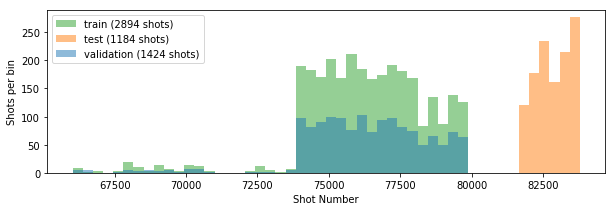

In [7]:
# Verify that all the data you are dealing with is carbon wall < 84000
fig, ax = plt.subplots(figsize=(10,3))

data = [shotlist_file.f.shot_list_validate,
        shotlist_file.f.shot_list_test,
        shotlist_file.f.shot_list_train]

data = [[s.number for s in f] for f in data]
labels = ['validation', 'test', 'train']
labels = [l+' ('+str(len(d))+' shots)' for (l,d) in zip(labels,data)]
ax.hist(data, label=labels, bins=50, alpha=0.5, histtype='stepfilled')
ax.legend(loc='upper left')
ax.set_xlabel('Shot Number')
ax.set_ylabel('Shots per bin')

max_shotnr = max([max(d) for d in data])
print(max_shotnr)

In [8]:
shotlist_val = shotlist_file.f.shot_list_validate

In [9]:
shot = shotlist_val[0]

In [10]:
pprint(shot.__dict__)

{'augmentation_fn': None,
 'is_disruptive': False,
 'machine': jet,
 'number': 75465,
 'signals': [q95 safety factor,
             internal inductance,
             plasma current,
             stored energy,
             Locked mode amplitude,
             Plasma density,
             Radiated Power Core,
             Radiated Power Edge,
             Radiated Power,
             Input Power (beam for d3d),
             stored energy time derivative],
 'signals_dict': None,
 't_disrupt': -1.0,
 'ttd': None,
 'valid': True,
 'weight': 1.0}


### Machines

In [11]:
jet = shot.signals[0].machines[0]
d3d = shot.signals[0].machines[1]

In [12]:
shot.machine.__dict__

{'name': 'jet',
 'server': 'mdsplus.jet.efda.org',
 'max_cores': 8,
 'fetch_data_fn': <function data.signals.fetch_jet_data(signal_path, shot_num, c)>,
 'current_threshold': 100000.0}

In [13]:
d3d.__dict__

{'name': 'd3d',
 'server': 'atlas.gat.com',
 'max_cores': 32,
 'fetch_data_fn': <function data.signals.fetch_d3d_data(signal_path, shot, c=None)>,
 'current_threshold': 0.2}

### Signals

In [14]:
df_jet_signals = []
df_d3d_signals = []

for sig in shot.signals:
    df = pd.DataFrame(sig.__dict__)
    row_jet = df.query('machines==@jet')
    row_d3d = df.query('machines==@d3d')
    if len(row_jet)==1:
        df_jet_signals.append(row_jet)
    if len(row_d3d)==1:
        df_d3d_signals.append(row_d3d)

In [15]:
df_jet_signals = pd.concat(df_jet_signals, sort=False, ignore_index=True,copy=False)
df_jet_signals

,description,paths,machines,causal_shifts,is_ip,num_channels,normalize,data_avail_tolerances,is_strictly_positive,mapping_paths,channel_nums
0,q95 safety factor,ppf/efit/q95,jet,15,False,1,False,0.03,False,None,NaN
1,internal inductance,jpf/gs/bl-li<s,jet,0,False,1,True,0.00,False,None,NaN
2,plasma current,jpf/da/c2-ipla,jet,0,True,1,True,0.00,False,None,NaN
3,stored energy,jpf/gs/bl-wmhd<s,jet,0,False,1,True,0.00,False,None,NaN
4,Locked mode amplitude,jpf/da/c2-loca,jet,0,False,1,True,0.00,False,None,NaN
5,Plasma density,jpf/df/g1r-lid:003,jet,0,False,1,True,0.00,True,None,NaN
6,Radiated Power Core,ppf/bolo/kb5h,jet,0,False,1,True,0.00,False,None,14.0
7,Radiated Power Edge,ppf/bolo/kb5h,jet,0,False,1,True,0.00,False,None,10.0
8,Radiated Power,jpf/db/b5r-ptot>out,jet,0,False,1,True,0.00,False,None,NaN
9,Input Power (beam for d3d),jpf/gs/bl-ptot<s,jet,0,False,1,True,0.00,False,None,NaN


In [16]:
# WARNING: This list will only be complete if the input processed data contains at least one DII-D shot!
df_d3d_signals = pd.concat(df_d3d_signals, sort=False, ignore_index=True,copy=False)
df_d3d_signals

,description,paths,machines,causal_shifts,is_ip,num_channels,normalize,data_avail_tolerances,is_strictly_positive,mapping_paths,channel_nums
0,q95 safety factor,EFIT01/RESULTS.AEQDSK.Q95,d3d,10,False,1,False,0.02,False,None,NaN
1,internal inductance,d3d/efsli,d3d,0,False,1,True,0.00,False,None,NaN
2,plasma current,d3d/ipspr15V,d3d,0,True,1,True,0.00,False,None,NaN
3,stored energy,d3d/efswmhd,d3d,0,False,1,True,0.00,False,None,NaN
4,Locked mode amplitude,d3d/dusbradial,d3d,0,False,1,True,0.00,False,None,NaN
5,Plasma density,d3d/dssdenest,d3d,0,False,1,True,0.00,True,None,NaN
6,Radiated Power Core,d3d/\bol_l15_p,d3d,0,False,1,True,0.00,False,None,NaN
7,Radiated Power Edge,d3d/\bol_l03_p,d3d,0,False,1,True,0.00,False,None,NaN
8,Input Power (beam for d3d),d3d/bmspinj,d3d,0,False,1,True,0.00,False,None,NaN


### Shots

In [17]:
shots_dir = indir+'processed_shots/signal_group_3236450206765786377241194018831785328/'
#all_files = glob.glob(shots_dir+'*.npz')
#vars(file)

Create a list of n disruptive and n nondisrutpive shots, taken from the jet validation set

In [18]:
disruptive_files = []
disruptive_shots = []

non_disruptive_files = []
non_disruptive_shots = []

max_n = 5

counter=0
for shot in shotlist_val:
    if len(disruptive_files)>max_n-1:
        break
        
    counter+=1
    clear_output(wait=True)
    
    if(shot.valid and shot.machine==jet):
        if shot.is_disruptive:
            file = np.load(shots_dir+str(shot.number)+'.npz', allow_pickle=True)
            disruptive_files.append(file)
            disruptive_shots.append(shot)
        elif(len(non_disruptive_files)<max_n):
            file = np.load(shots_dir+str(shot.number)+'.npz', allow_pickle=True)
            non_disruptive_files.append(file)
            non_disruptive_shots.append(shot)
        
    print('Found',len(disruptive_files), 'disruptions out of', counter, 'shots.')

Found 5 disruptions out of 73 shots.


In [19]:
index = 1
file = disruptive_files[index]
shot = disruptive_shots[index]

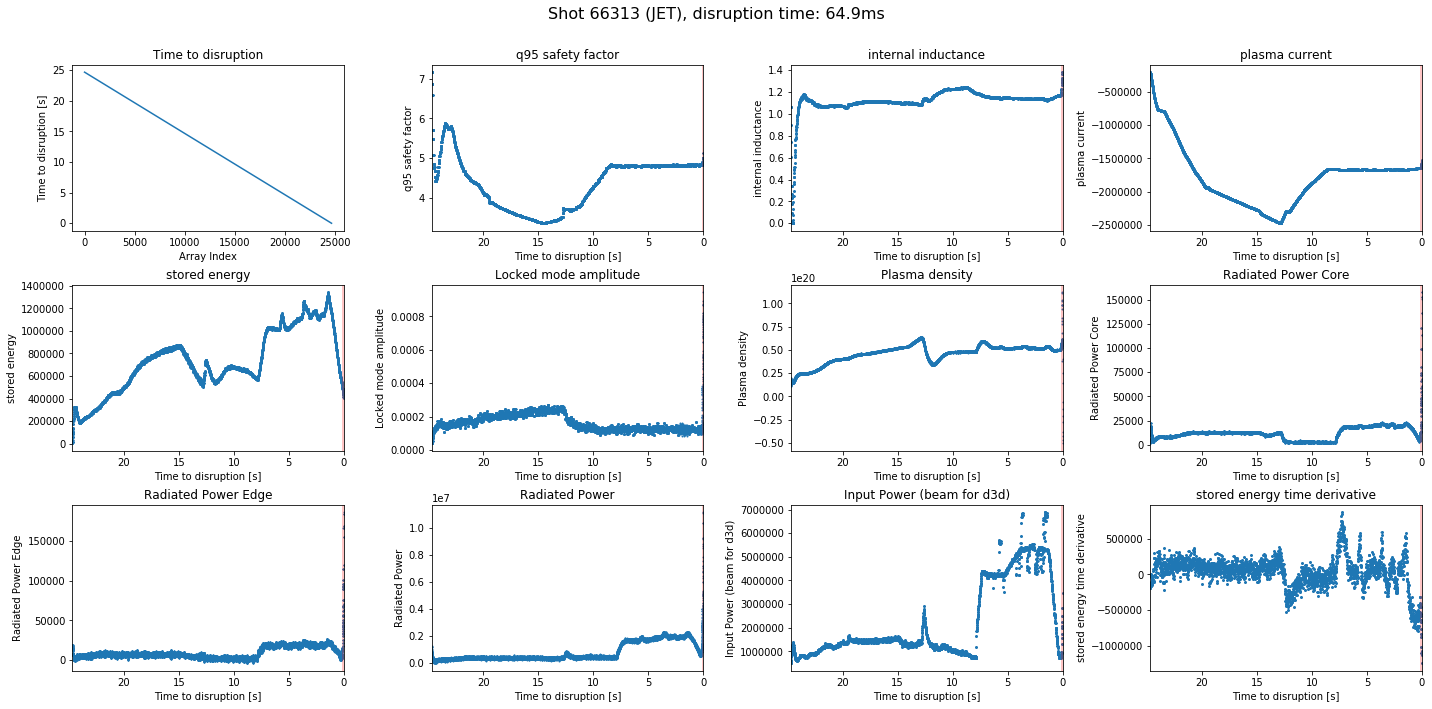

In [20]:
for shot, file in zip(disruptive_shots, disruptive_files):
    plot_shot(shot,file)
    break

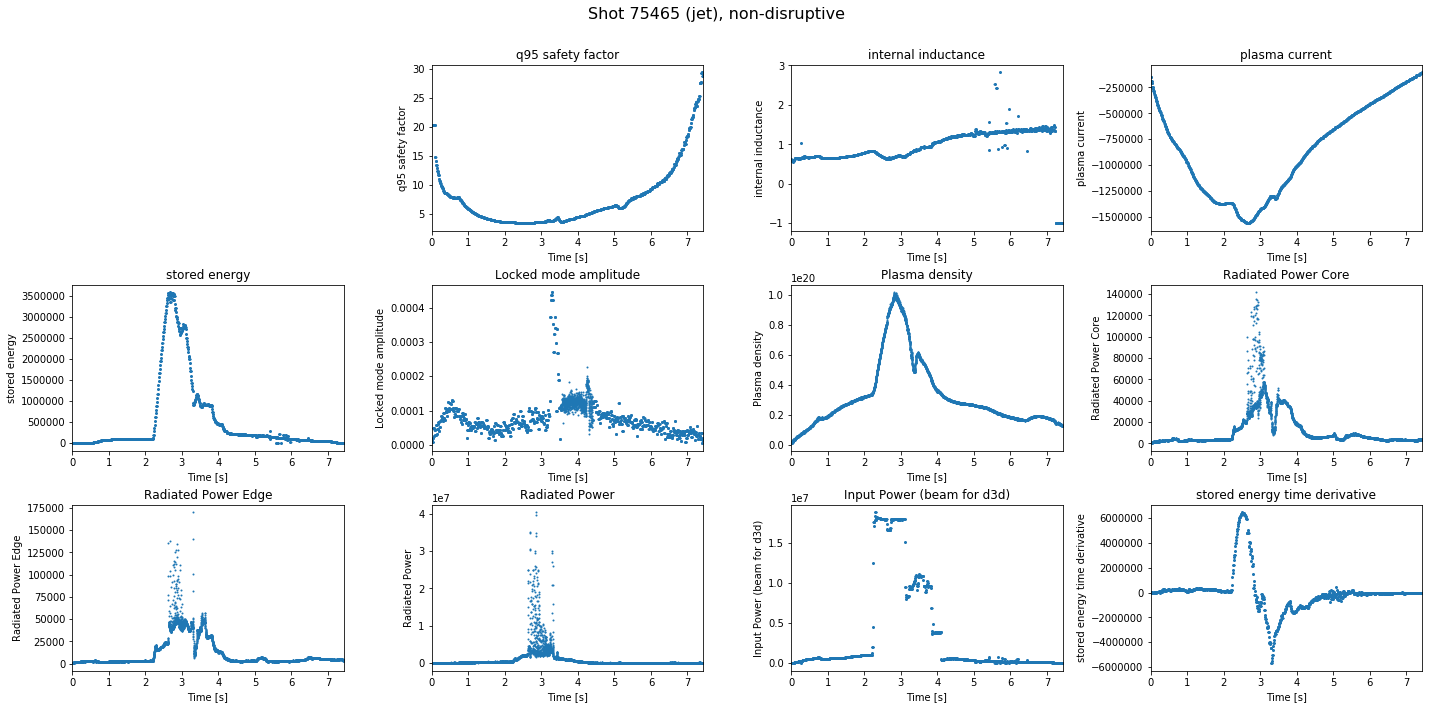

In [21]:
for shot, file in zip(non_disruptive_shots, non_disruptive_files):
    plot_shot(shot,file)
    break

### Look at the FFT of the signals

In [54]:
# Load specific file
index = 0
file = disruptive_files[index]
# load signals
signals_dict = file.f.signals_dict.item(0).items()
N = len(file.f.ttd)

In [55]:
# Configuration parameters
t_step = 0.001
t_min = 0
filter_size = 100
pad_width = 500 # pad with one second

In [56]:
# time array
t_max = len(file.f.ttd)*t_step
time = np.linspace(t_min, t_max, num=N)
# frequency array
N_padded = N+2*pad_width
freq = rfftfreq(N, d=t_step)
freq_padded = rfftfreq(N_padded, d=t_step)

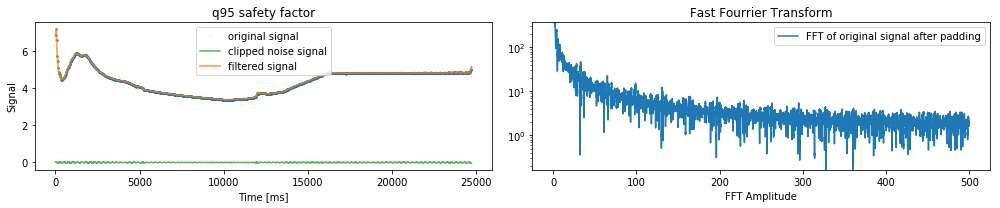

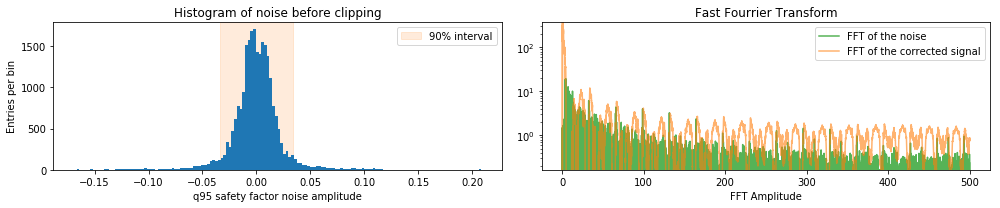

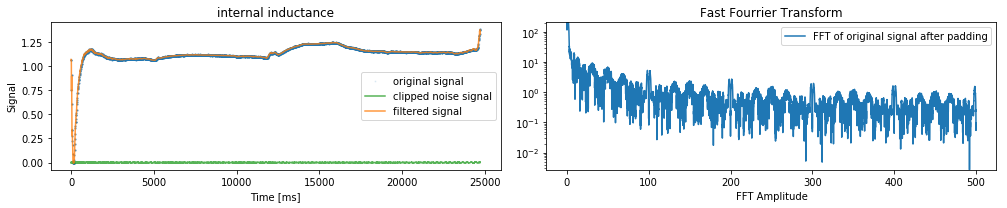

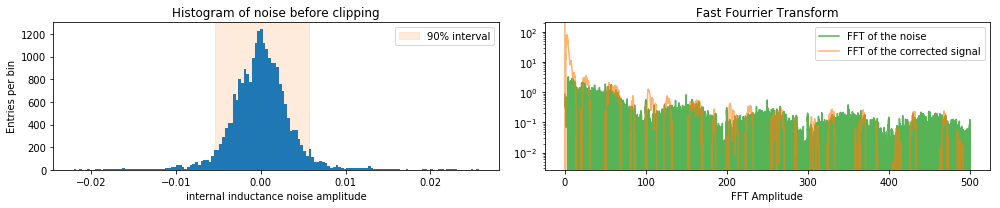

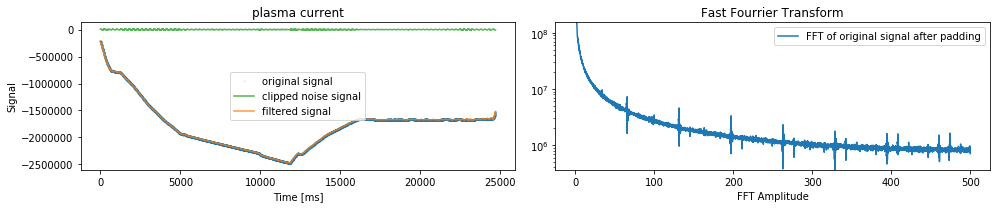

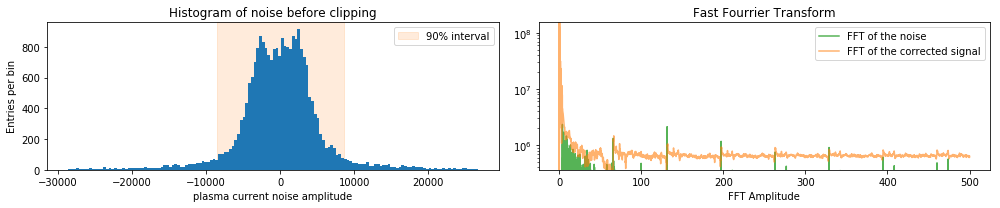

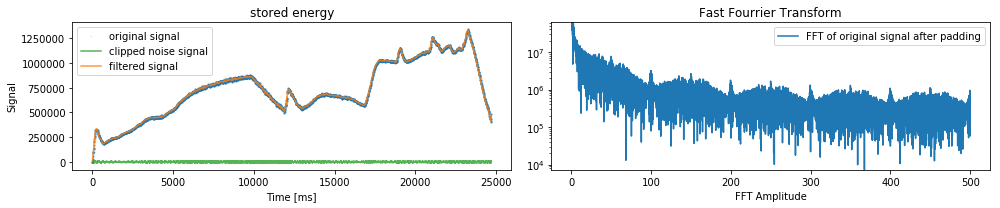

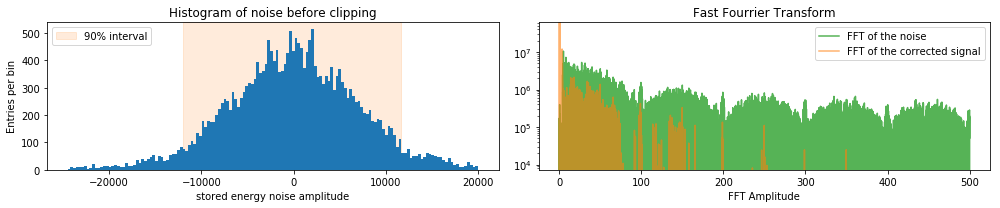

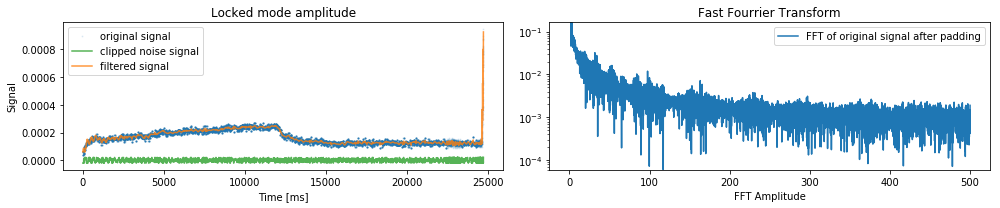

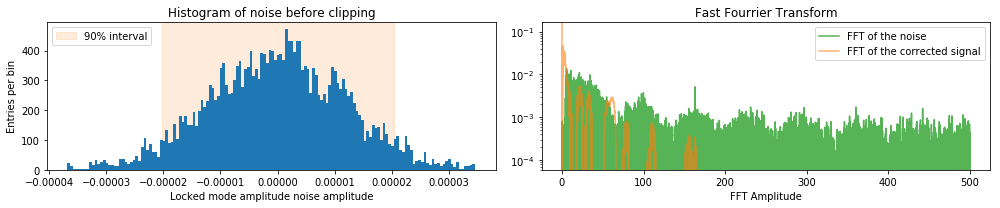

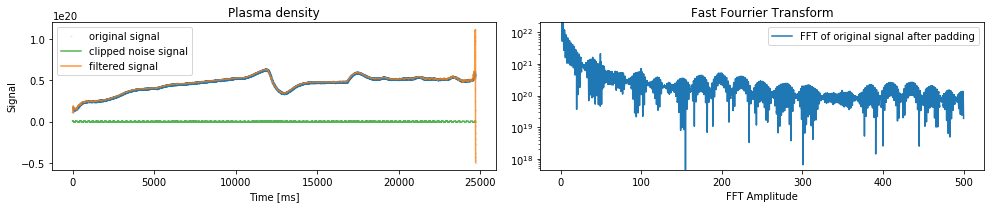

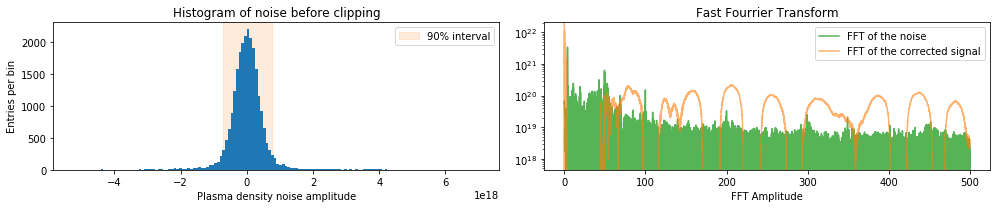

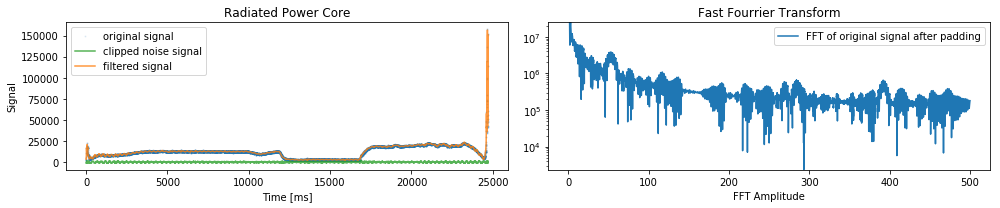

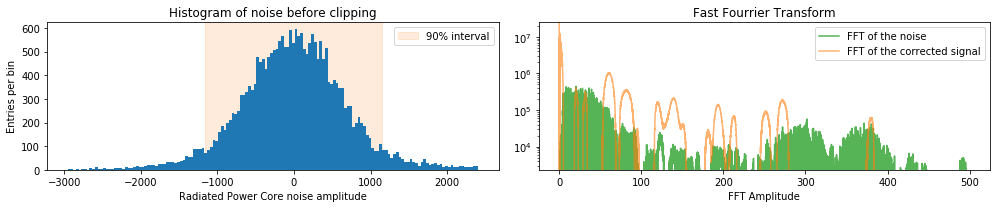

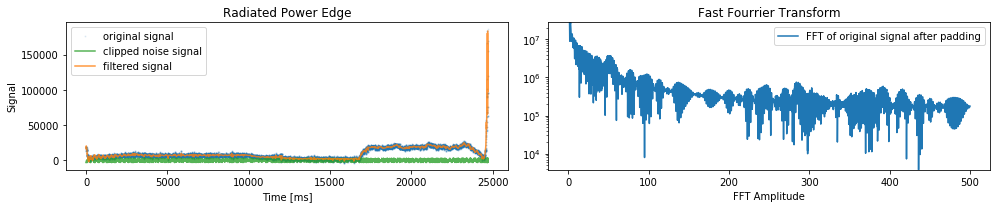

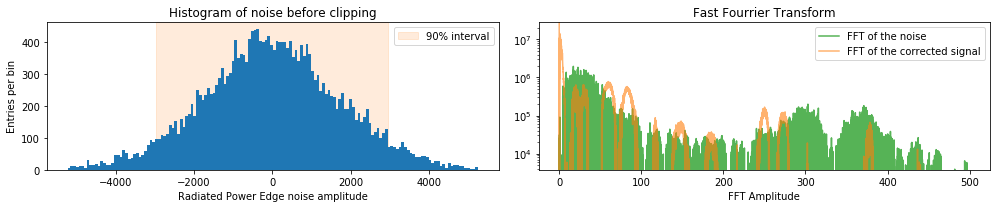

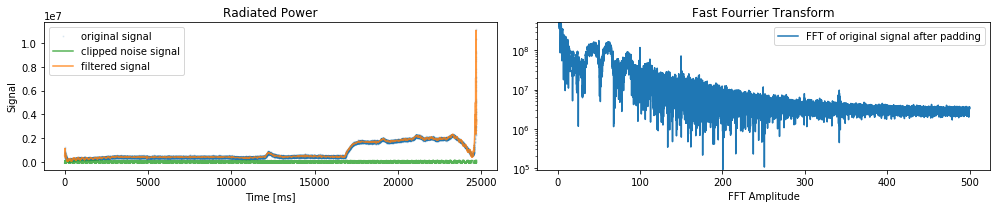

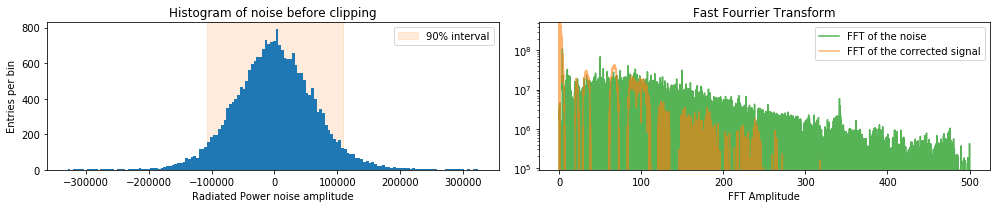

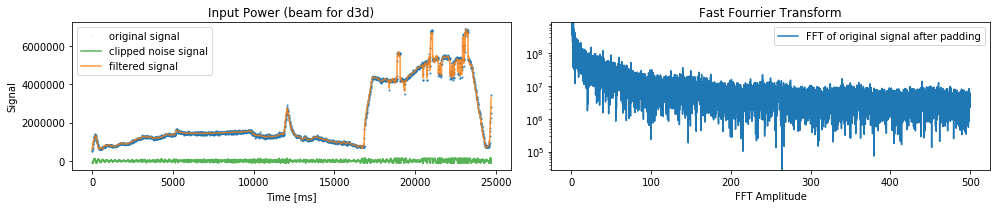

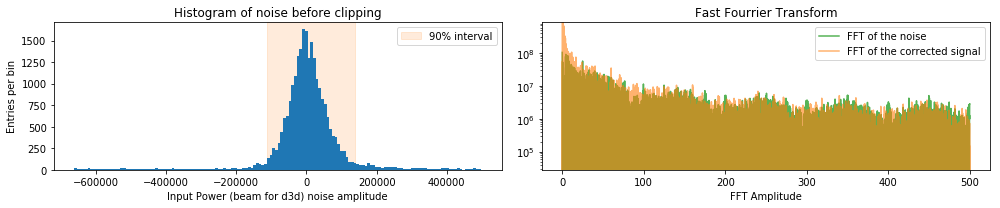

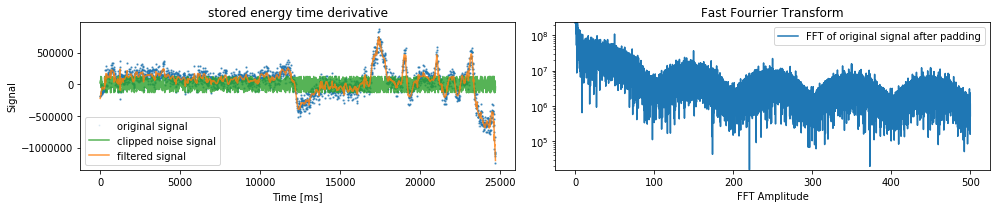

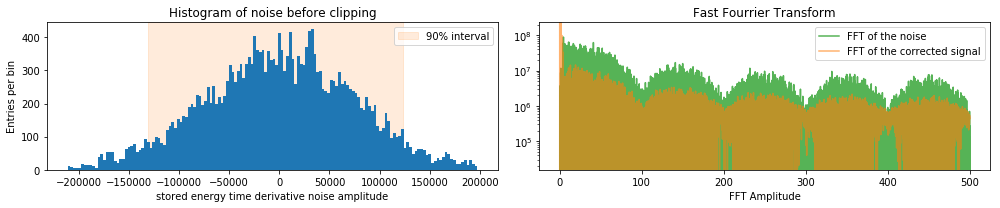

In [57]:
for i,(k,v) in enumerate(signals_dict):
    fig, ax = plt.subplots(ncols=2, figsize=(14,3))

    sig = v.flatten()
    padded_sig = np.pad(sig, pad_width, 'symmetric', reflect_type='odd')
    fftsig = rfft(padded_sig)
    N_padded = len(padded_sig)

    # Plot original signal on top
    ax[0].plot(sig, '.', markersize=2, label='original signal', alpha=0.1)
    ax[0].set_title(k)
    ax[0].set_xlabel('Time [ms]')
    ax[0].set_ylabel('Signal')

    # FFT of real valued serie is symmetric, only plot first half (rfft)
    fftsig_abs = np.abs(fftsig)
    ax[1].plot(freq_padded, fftsig_abs, label='FFT of original signal after padding')
    ax[1].set_ylim(min(fftsig_abs),max(fftsig_abs[50:]))
    ax[1].set_title('Fast Fourrier Transform')
    ax[1].set_xlabel(r'Frequency [Hz$^{-1}$]')
    ax[1].set_xlabel(r'FFT Amplitude')
    ax[1].set_yscale('log')
    ax[1].legend()
   
    fftsig_noise = np.zeros(len(freq_padded), dtype='complex64')
    fftsig_noise[filter_size:] = fftsig[filter_size:]
    
    ifftsig_noise = irfft(fftsig_noise)
    noise = ifftsig_noise[pad_width:-pad_width]
    plot_lower,lower, upper, plot_upper = np.percentile(noise,(0.5,5,95,99.5))
    noise_clip = np.clip(noise,lower,upper)

    ax[0].plot(noise_clip, label='clipped noise signal', alpha=0.8, color='C2')
    ax[0].plot(sig-noise_clip, label='filtered signal', alpha=0.8, color='C1')
    ax[0].legend()
    fig.tight_layout()
    fig.savefig(outdir+str(k).replace(" ", "")+'_fft.png', dpi=300)
    fig.show()

    fig, ax = plt.subplots(ncols=2, figsize=(14,3))
    ax[0].axvspan(xmin=lower, xmax=upper,color='C1', alpha=0.15, label='90% interval')
    ax[0].hist(noise, bins=150, range=(plot_lower, plot_upper))
    ax[0].set_title('Histogram of noise before clipping')
    ax[0].legend()
    ax[0].set_xlabel(str(k)+' noise amplitude')
    ax[0].set_ylabel('Entries per bin')

    ax[1].plot(freq, rfft(noise_clip), label='FFT of the noise', alpha=0.8, color='C2')
    ax[1].plot(freq, rfft(sig-noise_clip), label='FFT of the corrected signal', alpha=0.6, color='C1')
    ax[1].set_ylim(min(fftsig_abs),max(fftsig_abs[50:]))
    ax[1].set_xlabel(r'Frequency [Hz$^{-1}$]')
    ax[1].legend()
    ax[1].set_yscale('log')
    ax[1].set_title('Fast Fourrier Transform')
    ax[1].set_xlabel(r'FFT Amplitude')

    fig.tight_layout()
    fig.savefig(outdir+str(k).replace(" ", "")+'_fft_noise.png', dpi=300)
    plt.show()

### Plot the noise over time

In [ ]:
i=1 # The signal selection
counter=0
N_shots_non_disruptive = sum([~shot.is_disruptive for shot in shotlist_file.f.shot_list_validate])

stats_non_disruptive = []

for shot in shotlist_file.f.shot_list_validate:
    if(shot.valid and shot.machine==jet):
        if not shot.is_disruptive:
            file = np.load(shots_dir+str(shot.number)+'.npz', allow_pickle=True)
            
            signals_dict = file.f.signals_dict.item(0)
            items = list(signals_dict.items())

            pad_width = 500 # pad with one second
            sig = items[i][1].flatten()
            padded_sig = np.pad(sig, pad_width, 'symmetric', reflect_type='odd')
            fftsig = fft(padded_sig)
            N = len(sig)
            N_padded = len(padded_sig)

            filter_size=100    
            fftsig_noise = np.zeros(N_padded, dtype='complex64')
            fftsig_noise[filter_size:-filter_size] = fftsig[filter_size:-filter_size]
            ifftsig_noise = np.real(ifft(fftsig_noise))
            noise = ifftsig_noise[pad_width:-pad_width]
            plot_lower,lower, middle, upper, plot_upper = np.percentile(noise,(0.5,5,50,95,99.5))
            stats_non_disruptive.append([shot.number, plot_lower,lower, middle, upper, plot_upper])
            counter+=1
            clear_output(wait=True)
            print(counter, '/',N_shots_non_disruptive)

In [ ]:
array_non_disruptive = np.array(stats_non_disruptive).T
var = array_non_disruptive[3] - array_non_disruptive[1]
plt.hist(var,bins=40)

### Done!
Sandbox...

In [ ]:
array_non_disruptive[3]